In [1]:
# setup
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


from model_helpers import preprocess_data, validate_data, evaluate_model, log_transform

data_location = '../data/raw/psp_raw_data.xlsx'

In [2]:
# Load and preprocess data
df = pd.read_excel(data_location, index_col=0)
df = preprocess_data(df)
print(validate_data(df))

# Feature lists
categorical_features = ['country', 'card', 'psp']
binary_features = ['3d_secured']  # already in correct format 1/0
numerical_features = ['amount']

# Define features and target
X = df.drop(columns=['success'])
y = df['success']

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', FunctionTransformer(log_transform, validate=True)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop=None), categorical_features),  # Don't drop for interpretability
        ('binary', 'passthrough', binary_features)
    ]
)

classifier = XGBClassifier(n_estimators=100, random_state=42)

# Model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Train-test split, 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train) 

# Predict on the test set
y_test_pred = pipeline.predict(X_test)


Validation complete and successful.
None


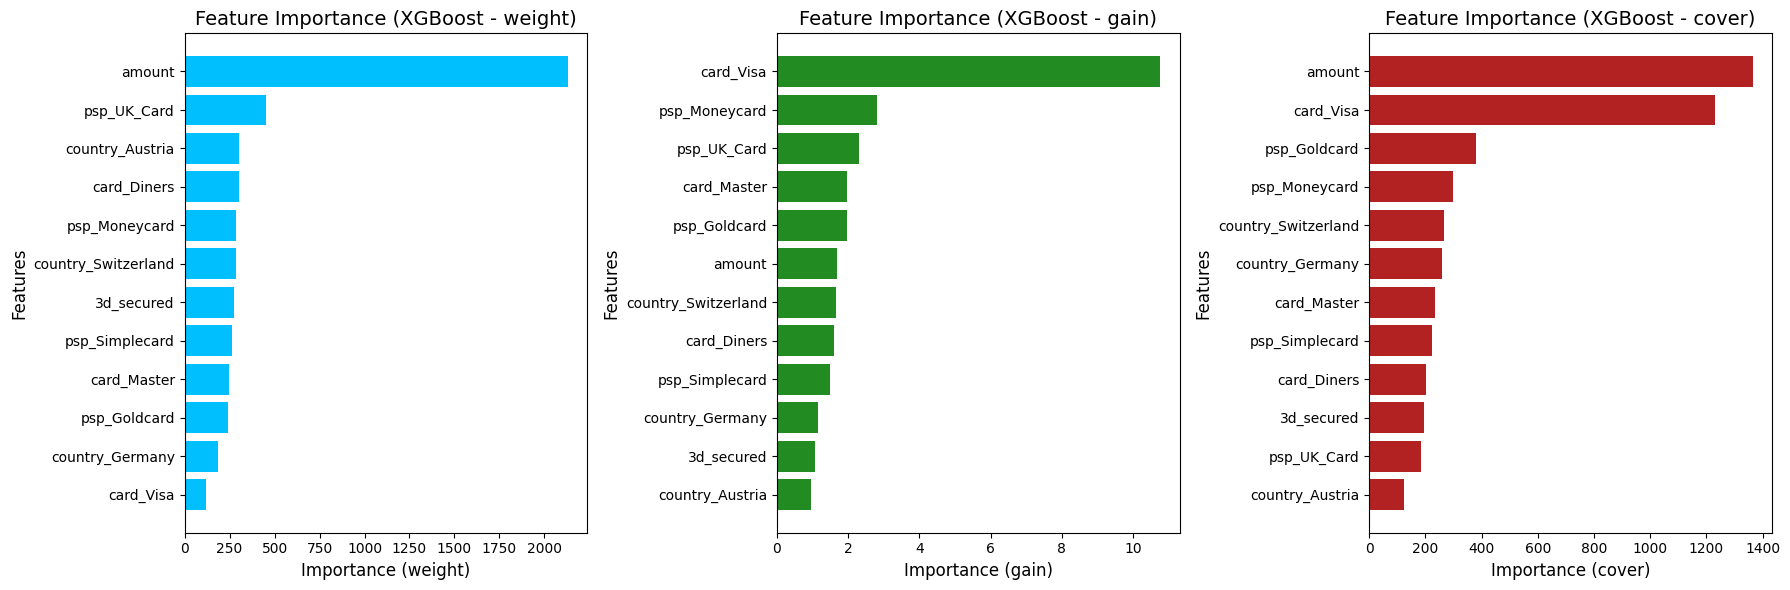

In [3]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Extract the classifier from the pipeline
model = pipeline.named_steps['classifier']

# Get feature names after preprocessing 
one_hot_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + binary_features + list(one_hot_columns)

# Define importance types
importance_types = ['weight', 'gain', 'cover']
importance_scores = {}

# Get feature importance scores for each definedtype
for importance_type in importance_types:
    feature_importance = model.get_booster().get_score(importance_type=importance_type)
    feature_importance = {all_feature_names[int(key[1:])]: value for key, value in feature_importance.items()}
    importance_scores[importance_type] = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, importance_type in zip(axes, importance_types):
    features = list(importance_scores[importance_type].keys())
    importances = list(importance_scores[importance_type].values())
    ax.barh(features, importances, color=['deepskyblue', 'forestgreen', 'firebrick'][importance_types.index(importance_type)])
    ax.set_xlabel(f'Importance ({importance_type})', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)
    ax.set_title(f'Feature Importance (XGBoost - {importance_type})', fontsize=14)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_delta_step=0.1, classifier__max_depth=3, classifier__reg_alpha=0, classifier__scale_pos_weight=1, classifier__subsample=0.7; total time=   0.2s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_delta_step=0.1, classifier__max_depth=3, classifier__reg_alpha=0, classifier__scale_pos_weight=1, classifier__subsample=0.7; total time=   0.2s
[CV] END classifier__colsample_bytree=0.7, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_delta_step=0.1, classifier__max_depth=6, classifier__reg_alpha=0, classifier__scale_pos_weight=3, classifier__subsample=1.0; total time=   0.3s
[CV] END classifier__colsample_bytree=1.0, classifier__gamma=0.1, classifier__learning_rate=0.2, classifier__max_delta_step=0.1, classifier__max_depth=3, classifier__re

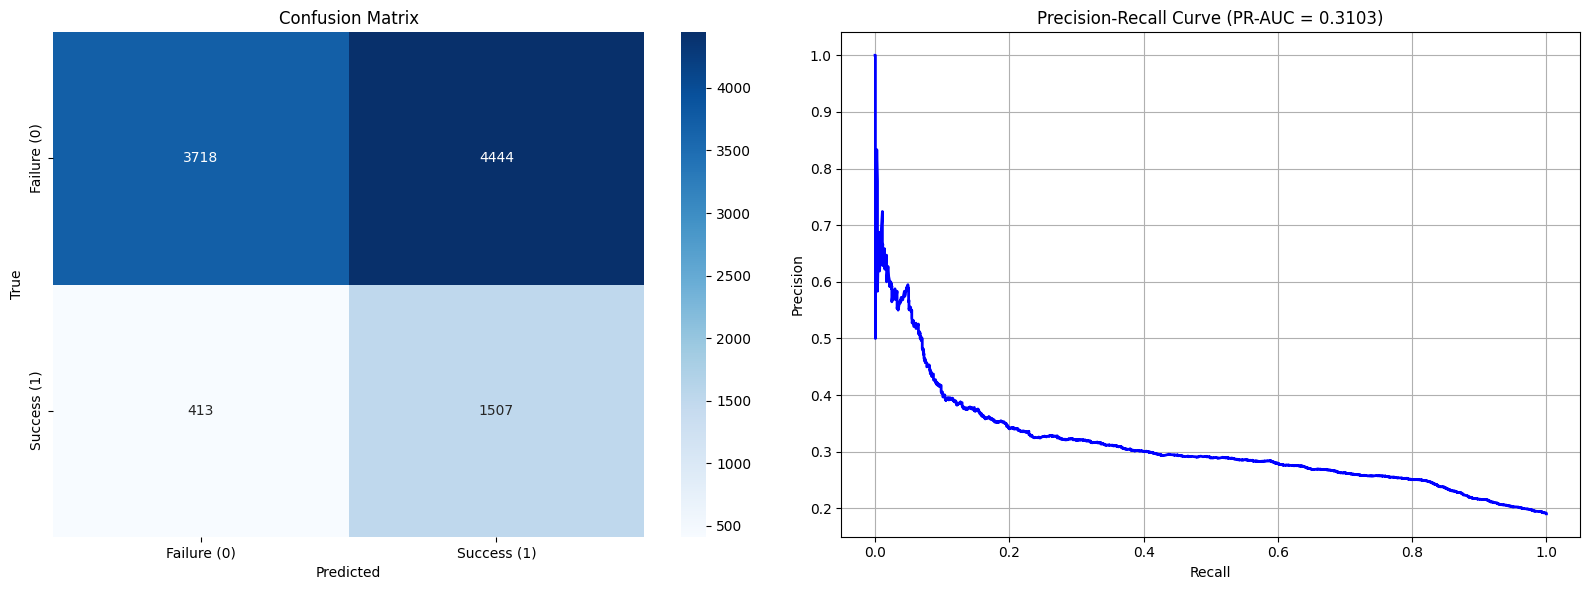


Classification Report:


,precision,recall,f1-score,support
Failure (0),0.900024,0.455526,0.604897,8162.00000
Success (1),0.253235,0.784896,0.382925,1920.00000
accuracy,0.518250,0.518250,0.518250,0.51825
macro avg,0.576629,0.620211,0.493911,10082.00000
weighted avg,0.776851,0.518250,0.562625,10082.00000


Best F1-Score: 0.3842 at Threshold: 0.5251
Total Model F1-Score: 0.3829
Total Model Precision: 0.2532


In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np

# Define the parameter grid for XGBoost hyperparameters
param_dist = {
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 6, 10],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 3, 5, 10, 20],  # Test higher values for class imbalance
    'classifier__max_delta_step': [0.1, 0.2, 0.5],  # Experiment with different steps
    'classifier__gamma': [0, 0.1, 0.5, 1],  # Try different gamma values
    'classifier__reg_alpha': [0, 0.1, 0.5],  # Test L1 regularization for model stability
}

# Initialize RandomizedSearchCV with 100 iterations for random sampling
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, 
                                   n_iter=100, scoring='f1', cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit random search
random_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best hyperparameters found: ", random_search.best_params_)

# Best model from random search
random_search_model = random_search.best_estimator_

# Evaluate the tuned model using custom function
evaluate_model(random_search_model, X_test, y_test)


### Evaluate overall model performance in terms of over/underfitting

In [6]:
# Evaluate on training data
y_train_pred = random_search_model.predict(X_train)
train_report = classification_report(y_train, y_train_pred)

# Evaluate on test data
y_test_pred = random_search_model.predict(X_test)
test_report = classification_report(y_test, y_test_pred)

# Print both classification reports
print("Train Classification Report:")
print(train_report)
print("\nTest Classification Report:")
print(test_report)

Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.46      0.61     32020
           1       0.28      0.79      0.41      8308

    accuracy                           0.53     40328
   macro avg       0.59      0.63      0.51     40328
weighted avg       0.77      0.53      0.57     40328


Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.46      0.60      8162
           1       0.25      0.78      0.38      1920

    accuracy                           0.52     10082
   macro avg       0.58      0.62      0.49     10082
weighted avg       0.78      0.52      0.56     10082



### Model Evaluation Summary
### Key Insights:
- **Similar performance** on both training and test datasets, indicating that the model is **not overfitting**.
- **Low precision for Success class (1)** and high recall suggest that the model identifies most successful transactions but struggles with false positives.
- **Model is slightly underfitting**: While the model shows consistency across both datasets, the overall performance (especially in precision for Success class) could be improved.
  
### Conclusion:
- The model does not exhibit signs of **overfitting**, but it is experiencing some level of **underfitting**, particularly in distinguishing between success and failure.